In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/26 16:02:39 WARN Utils: Your hostname, Duys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.30.28.97 instead (on interface en0)
25/05/26 16:02:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/26 16:02:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [1]:
a = ''

In [26]:
import os
import requests
from datetime import datetime, timedelta

def generate_yellow_cab_urls():
    start_year=2023
    base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data"
    today = datetime.today()
    first_day_this_month = datetime(today.year, today.month, 1)
    last_month = first_day_this_month - timedelta(days=1)

    end_year, end_month = last_month.year, last_month.month
    urls = []

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == end_year and month > end_month:
                break
            filename = f"yellow_tripdata_{year}-{month:02}.parquet"
            url = f"{base_url}/{filename}"
            urls.append((filename, url))

    return urls


generate_yellow_cab_urls()

[('yellow_tripdata_2023-01.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'),
 ('yellow_tripdata_2023-02.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'),
 ('yellow_tripdata_2023-03.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet'),
 ('yellow_tripdata_2023-04.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet'),
 ('yellow_tripdata_2023-05.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-05.parquet'),
 ('yellow_tripdata_2023-06.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-06.parquet'),
 ('yellow_tripdata_2023-07.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-07.parquet'),
 ('yellow_tripdata_2023-08.parquet',
  'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-08.parquet'),
 ('yellow_tripda

In [31]:
def download_missing_files():
    raw_folder="raw"
    os.makedirs(raw_folder, exist_ok=True)

    existing_files = set(os.listdir(raw_folder))
    all_files = generate_yellow_cab_urls()

    for filename, url in all_files:
        if filename in existing_files:
            print(f"Skipped (downloaded): {filename}")
            continue

        print(f"Downloading: {filename}")
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(os.path.join(raw_folder, filename), 'wb') as f:
                f.write(r.content)
            print(f"Saved: {filename}")
        except Exception as e:
            print(f"Failed: {filename} — {e}")

if __name__ == "__main__":
    download_missing_files()

Skipped (downloaded): yellow_tripdata_2023-01.parquet
Skipped (downloaded): yellow_tripdata_2023-02.parquet
Skipped (downloaded): yellow_tripdata_2023-03.parquet
Skipped (downloaded): yellow_tripdata_2023-04.parquet
Skipped (downloaded): yellow_tripdata_2023-05.parquet
Skipped (downloaded): yellow_tripdata_2023-06.parquet
Skipped (downloaded): yellow_tripdata_2023-07.parquet
Skipped (downloaded): yellow_tripdata_2023-08.parquet
Skipped (downloaded): yellow_tripdata_2023-09.parquet
Skipped (downloaded): yellow_tripdata_2023-10.parquet
Skipped (downloaded): yellow_tripdata_2023-11.parquet
Skipped (downloaded): yellow_tripdata_2023-12.parquet
Skipped (downloaded): yellow_tripdata_2024-01.parquet
Skipped (downloaded): yellow_tripdata_2024-02.parquet
Skipped (downloaded): yellow_tripdata_2024-03.parquet
Skipped (downloaded): yellow_tripdata_2024-04.parquet
Skipped (downloaded): yellow_tripdata_2024-05.parquet
Skipped (downloaded): yellow_tripdata_2024-06.parquet
Skipped (downloaded): yellow

In [7]:
from pyspark.sql import SparkSession
spark = (
        SparkSession.builder
        .appName("Combine2023_2024")
        .master("local[*]")
        .config("spark.driver.memory", "6g")  # ⬅️ bump this to 6–8g
        .getOrCreate()
    )

In [1]:
from pyspark.sql import SparkSession
import os

def combine_parquet_files(raw_dir="raw", output_path="data/bronze/combined_2023_2024.parquet"):
    spark = (
        SparkSession.builder
        .appName("Combine2023_2024")
        .master("local[*]")
        .config("spark.driver.memory", "6g")  # ⬅️ bump this to 6–8g
        .getOrCreate()
    )

    all_files = sorted(os.listdir(raw_dir))

    training_files = [
        f for f in all_files
        if f[0:21] == "yellow_tripdata_2023-" or f[0:21] == "yellow_tripdata_2024-"
    ]
    full_paths = [os.path.join(raw_dir, f) for f in training_files]

    combined_df = None

    for path in full_paths:
        print(f"Processing: {path}")
        df = spark.read.parquet(path)
        if combined_df is None:
            combined_df = df
        else:
            combined_df = combined_df.union(df)
    if combined_df is not None:
        combined_df = combined_df.repartition(6)
        combined_df.write.mode("overwrite").parquet(output_path)
        print(f"Combined data saved to: {output_path}")
    else:
        print("No files matched.")

if __name__ == "__main__":
    combine_parquet_files()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/25 18:08:55 WARN Utils: Your hostname, Duys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.30.28.230 instead (on interface en0)
25/05/25 18:08:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 18:08:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Processing: raw/yellow_tripdata_2023-01.parquet
Processing: raw/yellow_tripdata_2023-02.parquet
Processing: raw/yellow_tripdata_2023-03.parquet
Processing: raw/yellow_tripdata_2023-04.parquet
Processing: raw/yellow_tripdata_2023-05.parquet
Processing: raw/yellow_tripdata_2023-06.parquet
Processing: raw/yellow_tripdata_2023-07.parquet
Processing: raw/yellow_tripdata_2023-08.parquet
Processing: raw/yellow_tripdata_2023-09.parquet
Processing: raw/yellow_tripdata_2023-10.parquet
Processing: raw/yellow_tripdata_2023-11.parquet
Processing: raw/yellow_tripdata_2023-12.parquet
Processing: raw/yellow_tripdata_2024-01.parquet
Processing: raw/yellow_tripdata_2024-02.parquet
Processing: raw/yellow_tripdata_2024-03.parquet
Processing: raw/yellow_tripdata_2024-04.parquet
Processing: raw/yellow_tripdata_2024-05.parquet
Processing: raw/yellow_tripdata_2024-06.parquet
Processing: raw/yellow_tripdata_2024-07.parquet
Processing: raw/yellow_tripdata_2024-08.parquet
Processing: raw/yellow_tripdata_2024-09.

Combined data saved to: data/bronze/combined_2023_2024.parquet


In [6]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("Combine2023_2024")
    .master("local[*]")
    .config("spark.driver.memory", "6g")  # ⬅️ bump this to 6–8g
    .getOrCreate()
)


In [7]:
df = spark.read.parquet("data/bronze/combined_2023_2024.parquet")


In [8]:
zone_df = spark.read.option("header", True).csv("raw/taxi_zone_lookup.csv")

In [9]:
from pyspark.sql.functions import col  # ✅ add this


In [10]:
df = df.join(
    zone_df.withColumnRenamed("LocationID", "pu_zone_id")
           .withColumnRenamed("Zone", "pu_zone")
           .withColumnRenamed("Borough", "pu_borough")
           .withColumnRenamed("service_zone", "pu_service_zone"),
    df.PULocationID == col("pu_zone_id"),
    how="left"
).drop("zone_id")  # optional cleanup

In [11]:
df = df.join(
    zone_df.withColumnRenamed("LocationID", "do_zone_id")
           .withColumnRenamed("Zone", "do_zone")
           .withColumnRenamed("Borough", "do_borough")
           .withColumnRenamed("service_zone", "do_service_zone"),
    df.DOLocationID == col("do_zone_id"),
    how="left"
).drop("zone_id")  # optional cleanup

In [12]:
df.drop('do_zone_id','pu_zone_id','PULocationID','DOLocationID')

DataFrame[VendorID: bigint, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double, pu_borough: string, pu_zone: string, pu_service_zone: string, do_borough: string, do_zone: string, do_service_zone: string]

In [13]:
df = df.drop('do_zone_id','pu_zone_id','PULocationID','DOLocationID')

In [14]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pu_borough',
 'pu_zone',
 'pu_service_zone',
 'do_borough',
 'do_zone',
 'do_service_zone']

In [48]:
from pyspark.sql import functions as F

df.groupBy("pu_borough").count().show()

+-------------+--------+
|   pu_borough|   count|
+-------------+--------+
|       Queens| 7648677|
|          EWR|   11047|
|      Unknown|  478929|
|     Brooklyn|  881586|
|Staten Island|    4382|
|          N/A|   54489|
|    Manhattan|70208282|
|        Bronx|  192554|
+-------------+--------+



In [ ]:
import requests
import pandas as pd
from datetime import datetime

# Borough coordinates (approximate centers)
borough_coords = {
    "Manhattan": (40.7831, -73.9712),
    "Brooklyn": (40.6782, -73.9442),
    "Queens": (40.7282, -73.7949),
    "Bronx": (40.8448, -73.8648),
    "Staten Island": (40.5795, -74.1502)
}

# Date range for weather matching your taxi data
start_date = "2023-01-01"
end_date = "2024-12-31"
timezone = "America/New_York"
weather_vars = ["temperature_2m", "precipitation", "windspeed_10m", "cloudcover"]

base_url = "https://archive-api.open-meteo.com/v1/archive"

all_weather = []

for borough, (lat, lon) in borough_coords.items():
    print(f"📡 Fetching weather for {borough}...")
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(weather_vars),
        "timezone": timezone
    }
    r = requests.get(base_url, params=params)
    r.raise_for_status()
    raw_data = r.json()["hourly"]
    df = pd.DataFrame(raw_data)
    df["borough"] = borough
    df["time"] = pd.to_datetime(df["time"])
    all_weather.append(df)

# Combine all boroughs
weather_df = pd.concat(all_weather)
weather_df.to_csv("nyc_weather_by_borough.csv", index=False)
print(" Saved: nyc_weather_by_borough.csv")

📡 Fetching weather for Manhattan...
📡 Fetching weather for Brooklyn...
📡 Fetching weather for Queens...
📡 Fetching weather for Bronx...
📡 Fetching weather for Staten Island...
✅ Saved: nyc_weather_by_borough.csv


In [64]:
len(weather_df)

87720

In [65]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+---------------

In [15]:
from pyspark.sql.functions import date_trunc

df = df.withColumn("pickup_hour", date_trunc("hour", "tpep_pickup_datetime"))


In [16]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+--

In [17]:
from pyspark.sql.functions import unix_timestamp, round

df = df.withColumn(
    "trip_duration_min",
    round((unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60, 2)
)


In [71]:
weather_df.head()

,time,temperature_2m,precipitation,windspeed_10m,cloudcover,borough
0,2023-01-01 00:00:00,10.8,1.1,11.7,100,Manhattan
1,2023-01-01 01:00:00,10.8,0.9,9.1,100,Manhattan
2,2023-01-01 02:00:00,10.7,0.1,14.4,94,Manhattan
3,2023-01-01 03:00:00,10.7,0.0,16.6,9,Manhattan
4,2023-01-01 04:00:00,10.0,0.0,16.9,1,Manhattan


In [18]:
weather_df = spark.read.option("header", True).csv('nyc_weather_by_borough.csv')

In [20]:
from pyspark.sql.functions import col

weather_columns = ["temperature_2m", "precipitation", "windspeed_10m", "cloudcover"]

for col_name in weather_columns:
    weather_df = weather_df.withColumn(col_name, col(col_name).cast("double"))

weather_df.printSchema()  # ✅ Confirm all types are now double

root
 |-- time: string (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- windspeed_10m: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- borough: string (nullable = true)



In [82]:
from pyspark.sql.functions import col

df = df.join(
    weather_df,
    (df["pickup_hour"] == weather_df["time"]) & 
    (df["pu_borough"] == weather_df["borough"]),
    how="left"
)


In [85]:
df = df.drop('time','borough')

In [21]:
rain_snow_df = spark.read.csv('nyc_weather_rain_snow.csv', header=True)

weather_columns = ["rain", "snowfall"]

for col_name in weather_columns:
    rain_snow_df = rain_snow_df.withColumn(col_name, col(col_name).cast("double"))

rain_snow_df.printSchema()  # ✅ Confirm all types are now double

root
 |-- time: string (nullable = true)
 |-- rain: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- borough: string (nullable = true)



In [24]:
weather_df.printSchema()

root
 |-- time: string (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- windspeed_10m: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- borough: string (nullable = true)



In [25]:
# Register both DataFrames as temp views
df.createOrReplaceTempView("main")
rain_snow_df.createOrReplaceTempView("rain_snow")
weather_df.createOrReplaceTempView("weather")

# Use Spark SQL with expr
df = spark.sql("""
    SELECT m.*,
            w.temperature_2m,
            w.precipitation,
            w.windspeed_10m,
            w.cloudcover,
            r.rain, 
            r.snowfall
    FROM main m
    LEFT JOIN weather w
        ON m.pickup_hour = w.time AND m.pu_borough = w.borough
    LEFT JOIN rain_snow r
    ON m.pickup_hour = r.time AND m.pu_borough = r.borough
""")


In [26]:
df.show()

25/05/25 18:23:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|
+--------+--------------------+---------------------+---------------+-------------+----------+------------

In [27]:
df.write \
  .mode("overwrite") \
  .option("compression", "snappy") \
  .parquet("temp_file/")


# things to do
* get holiday data
* feature engineer weather data
* null
* passenger <> 0
* fair >0 
* trip >0

In [16]:
from pyspark.sql.functions import expr


In [28]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|
+--------+--------------------+---------------------+---------------+-------------+----------+------------

In [ ]:
df.createOrReplaceTempView("main")

# 2. Run SQL to create new DataFrame with added column
df = spark.sql("""
    SELECT
        *,
        CASE 
            WHEN temperature_2m > 27 THEN 'Hot'
            WHEN temperature_2m > 15 THEN 'Warm'
            ELSE 'Cold'
        END AS temperature_category,
        CASE
            WHEN (precipitation > 2 OR rain > 2 OR 
            fall > 2) AND windspeed_10m > 5 AND cloudcover > 75 THEN 'Stormy'
            WHEN snowfall > 0 THEN 'Snowy'
            WHEN rain > 0 THEN 'Rainy'
            WHEN cloudcover > 75 THEN 'Overcast'
            WHEN windspeed_10m > 5 THEN 'Windy'
            WHEN cloudcover < 25 AND windspeed_10m < 2 THEN 'Clear and Calm'
            ELSE 'Partly Cloudy'
        END AS weather_condition_summary

    FROM main
""")

# 3. Write to Parquet
df.write.mode("overwrite").parquet("weather_features.parquet")


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LocalOptimizedSpark") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/31 15:01:39 WARN Utils: Your hostname, Duys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
25/05/31 15:01:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 15:01:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.parquet('weather_features.parquet')

In [3]:
df.createOrReplaceTempView("main")


25/05/26 20:17:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
unknown_pu =spark.sql("""
select
    *
from
    main
where
    pu_borough in ('Unknown','N/A')
"""         
)

In [3]:
df.show()

25/05/25 21:15:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [29]:
df.createOrReplaceTempView("main")


In [33]:
spark.sql("""
    SELECT
        weather_condition_summary,
          count(*) counts
    FROM main
    group by 1
    order by counts desc
""").show()

+-------------------------+--------+
|weather_condition_summary|  counts|
+-------------------------+--------+
|                    Windy|36183967|
|                 Overcast|27578584|
|                    Rainy| 9995805|
|            Partly Cloudy| 3090409|
|                   Stormy| 1540736|
|                    Snowy|  748245|
|           Clear and Calm|  342200|
+-------------------------+--------+



In [36]:
spark.sql("""
    SELECT
        temperature_category,
          count(*) counts
    FROM main
    group by 1
    order by counts desc
""").show()

+--------------------+--------+
|temperature_category|  counts|
+--------------------+--------+
|                Cold|43243971|
|                Warm|30727025|
|                 Hot| 5508950|
+--------------------+--------+



In [ ]:
spark.sql("""
    select distinct from main
""")

In [39]:
df.columns('trip_distance')

TypeError: 'list' object is not callable

In [42]:
df.select('trip_distance').describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|          79479946|
|   mean| 4.548482326094959|
| stddev|345.09841911656997|
|    min|               0.0|
|    max|         398608.62|
+-------+------------------+



In [44]:
spark.sql("""
    SELECT
        percentile_approx(trip_distance, 0.25) AS p25,
        percentile_approx(trip_distance, 0.5)  AS median,
        percentile_approx(trip_distance, 0.75) AS p75,
        AVG(trip_distance) AS mean,
        min(trip_distance),
        max(trip_distance)
    FROM main
""").show()


+----+------+---+-----------------+------------------+------------------+
| p25|median|p75|             mean|min(trip_distance)|max(trip_distance)|
+----+------+---+-----------------+------------------+------------------+
|1.03|  1.77|3.4|4.548482326094959|               0.0|         398608.62|
+----+------+---+-----------------+------------------+------------------+



In [45]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+-------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|            do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+----

In [48]:
spark.sql("select VendorID,count(*) from main group by 1  ").show()

+--------+--------+
|VendorID|count(1)|
+--------+--------+
|       6|   10737|
|       1|19753632|
|       2|59715347|
|       7|     230|
+--------+--------+



In [51]:
passenger_dist = spark.sql("""
SELECT 
    passenger_count,
    COUNT(*) AS count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent
FROM main
GROUP BY passenger_count
ORDER BY count DESC

""").show()

25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 1

+---------------+--------+-------+
|passenger_count|   count|percent|
+---------------+--------+-------+
|            1.0|56456162|  71.03|
|            2.0|11019879|  13.86|
|           NULL| 5400588|   6.79|
|            3.0| 2676766|   3.37|
|            4.0| 1604886|   2.02|
|            0.0|  984359|   1.24|
|            5.0|  803846|   1.01|
|            6.0|  532767|   0.67|
|            8.0|     453|   0.00|
|            7.0|     149|   0.00|
|            9.0|      91|   0.00|
+---------------+--------+-------+



25/05/25 19:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:11:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
x

## Notes
* trip distance for max range too large, need cut ( 3986... miles)
* vendor id is most like 1,2 Creative Mobile Technologies (CMT),	VeriFone Inc. (VTS) respectively , 6,7 irrelveant
* fare amount should be between 70 dollars and the ratecodeID =2
* https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf <- drive record passenger count, so driver can likely put wrong inputs


In [57]:
outliers = spark.sql("""
SELECT 
    *
FROM main
WHERE passenger_count = 9

""")

In [59]:
outliers.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [60]:
outliers.describe().show()

+-------+------------------+---------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+----------+-----------------+---------------+----------+-----------------+---------------+------------------+-----------------+------------------+-----------------+-----------------+-------------------+--------------------+--------------------+-------------------------+
|summary|          VendorID|passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        airport_fee|pu_borough|          pu_zone|pu_service_zone|do_borough|          do_zone|do_service_zone| trip_duration_min|   temperature_2m|     p

In [63]:
pmt_type = spark.sql("""
SELECT 
    payment_type,
    count(*) c,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent                
FROM main
group by 1
order by c desc
""")

In [64]:
pmt_type.show()

25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:29:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 1

+------------+--------+-------+
|payment_type|       c|percent|
+------------+--------+-------+
|           1|60309091|  75.88|
|           2|11945147|  15.03|
|           0| 5400588|   6.79|
|           4| 1292509|   1.63|
|           3|  532605|   0.67|
|           5|       6|   0.00|
+------------+--------+-------+



25/05/25 19:30:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:30:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:30:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 19:30:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [65]:
df.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+-------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|            do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+----

In [ ]:
flat_fare = spark.sql(
"""
SELECT *
FROM main
WHERE RatecodeID = 2

  AND (fare_amount < 60 OR fare_amount > 80)
  and fare_amount >0


""")

In [77]:
flat_fare.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [79]:
flat_fare.select('fare_amount').describe().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|             70881|
|   mean|-64.05252874536193|
| stddev| 704.8062114172561|
|    min|             -70.0|
|    max|         187502.96|
+-------+------------------+



In [84]:
test = spark.sql(
"""
select
    *
from
    main
where
    0>= fare_amount
""" 
)

In [85]:
test.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

25/05/25 20:26:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 760535 ms exceeds timeout 120000 ms
25/05/25 20:26:31 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/25 20:26:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [5]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [6]:
test = spark.sql(
    """
    SELECT
    *
    FROM
        main
    where passenger_count is null             
""")

In [7]:
test.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

# clean data
1. remove null rows/broken rows: payment_type = 0 and passenger is null 
2. rateid =2 then fair mostly around 2- pending check
3. ratecodeid = 2 then most likely fare_amount is 70, or close to 70. any negative -70 will flip to 70
4. half of fare amount <0 is dispute


In [14]:
df = spark.sql(
""" 
select
    *
from
    main
where
    passenger_count is not null and payment_type <> 0
"""    
)

In [15]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [18]:
spark.sql(
"""
    select
        fare_amount,
        count(*) c
    from
        main
    where
        fare_amount <0
    group by 1 order by c desc
"""
).show()

+-----------+------+
|fare_amount|     c|
+-----------+------+
|       -3.0|117897|
|      -70.0| 68348|
|       -6.5| 35798|
|       -7.2| 35740|
|       -7.9| 34840|
|       -5.8| 34130|
|       -8.6| 33454|
|       -9.3| 31971|
|      -10.0| 31877|
|       -1.0| 29797|
|       -5.1| 29699|
|      -10.7| 29307|
|      -11.4| 27874|
|       -3.7| 26850|
|      -12.1| 25919|
|       -4.4| 24790|
|      -12.8| 24218|
|      -13.5| 22831|
|      -14.2| 20545|
|      -14.9| 18484|
+-----------+------+
only showing top 20 rows


In [25]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [32]:
spark.sql(
"""
    select
        payment_type,
        count(*),
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent                
    from
        main
    group by 1
"""
).show()

25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:20:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 2

+------------+--------+-------+
|payment_type|count(1)|percent|
+------------+--------+-------+
|           0| 5400588|   6.79|
|           1|60309091|  75.88|
|           3|  532605|   0.67|
|           2|11945147|  15.03|
|           4| 1292509|   1.63|
|           5|       6|   0.00|
+------------+--------+-------+



In [ ]:
spark.sql(
"""
    select
        ratecodeID,
        count(*),
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent                
    from
        main
    where
        fare_amount <0
    group by 1
"""
).show()

25/05/25 22:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------+-------+
|ratecodeID|count(1)|percent|
+----------+--------+-------+
|      NULL|  133871|  12.03|
|       1.0|  871280|  78.31|
|       4.0|    6915|   0.62|
|       3.0|   11401|   1.02|
|       2.0|   67900|   6.10|
|       5.0|   21302|   1.91|
|       6.0|       5|   0.00|
+----------+--------+-------+



25/05/25 22:27:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:27:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:27:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:27:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [39]:
spark.sql(
"""
    select
        ratecodeID,
        sum( case when fare_amount < 0 then 1 else 0 end)/count(*)*100.0            
    from
        main
    group by 1
"""
).show()

+----------+-------------------------------------------------------------------------+
|ratecodeID|((sum(CASE WHEN (fare_amount < 0) THEN 1 ELSE 0 END) / count(1)) * 100.0)|
+----------+-------------------------------------------------------------------------+
|      NULL|                                                        2.478822676345613|
|       1.0|                                                       1.2528738354408426|
|       4.0|                                                       3.8612517938208804|
|       3.0|                                                        4.428346701365287|
|       2.0|                                                       2.3571502712805716|
|      99.0|                                                                      0.0|
|       6.0|                                                         3.64963503649635|
|       5.0|                                                       3.9513198580626256|
+----------+-------------------------------

In [ ]:
spark.sql(
"""
    select
        payment_type,
        count(*)       
    from
        main
    where
        fare_amount = -3
"""
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [43]:
spark.sql(
"""
    select
        payment_type,
        count(*),
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent                       
    from
        main
    where
        fare_amount <0
    group by 1
"""
).show()

25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------+--------+-------+
|payment_type|count(1)|percent|
+------------+--------+-------+
|           0|  133871|  12.03|
|           1|     474|   0.04|
|           3|  152663|  13.72|
|           2|  233065|  20.95|
|           4|  592601|  53.26|
+------------+--------+-------+



25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/25 22:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [45]:
spark.sql(
"""
    select
        fare_amount,
        payment_type,
        count(*) c                    
    from
        main
    where
        fare_amount <0
    group by 1,2
    order by c desc 
"""
).show()

+-----------+------------+-----+
|fare_amount|payment_type|    c|
+-----------+------------+-----+
|       -3.0|           4|43605|
|      -70.0|           4|36658|
|       -3.0|           3|35949|
|       -1.0|           0|29694|
|       -6.5|           4|21610|
|       -7.2|           4|21589|
|       -7.9|           4|21571|
|       -3.0|           0|21382|
|       -8.6|           4|21050|
|       -5.8|           4|20448|
|      -10.0|           4|20339|
|       -9.3|           4|20289|
|      -70.0|           2|19786|
|      -10.7|           4|18722|
|      -11.4|           4|17964|
|       -5.1|           4|17595|
|       -3.0|           2|16886|
|      -12.1|           4|16665|
|      -12.8|           4|15600|
|       -3.7|           4|15226|
+-----------+------------+-----+
only showing top 20 rows


In [4]:
spark.sql("""
SELECT 
  VendorID, pu_zone, 
  SUM(CASE WHEN fare_amount < 0 AND payment_type = 4 THEN 1 ELSE 0 END) AS dispute_count,
  COUNT(*) AS total_trips,
  ROUND(100.0 * SUM(CASE WHEN fare_amount < 0 AND payment_type = 4 THEN 1 ELSE 0 END) / COUNT(*), 2) AS dispute_rate_pct
FROM main
GROUP BY VendorID, pu_zone
ORDER BY dispute_rate_pct DESC
""").show()

+--------+--------------------+-------------+-----------+----------------+
|VendorID|             pu_zone|dispute_count|total_trips|dispute_rate_pct|
+--------+--------------------+-------------+-----------+----------------+
|       2|     Mariners Harbor|            6|         71|            8.45|
|       2|Marine Park/Floyd...|           57|        929|            6.14|
|       2|         Jamaica Bay|            4|         82|            4.88|
|       2|     Manhattan Beach|           34|        720|            4.72|
|       2|           Bellerose|           55|       1372|            4.01|
|       2|          Bath Beach|           24|        623|            3.85|
|       2|            Rosedale|           44|       1175|            3.74|
|       2|Bloomfield/Emerso...|            8|        216|            3.70|
|       2|       Willets Point|           12|        327|            3.67|
|       2|  Van Cortlandt Park|            9|        251|            3.59|
|       2|   Rossville/Wo

In [5]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [6]:
spark.sql("""
select
    pu_borough,
    count(*)
from
    main
group by 1
"""         
).show()

+-------------+--------+
|   pu_borough|count(1)|
+-------------+--------+
|       Queens| 7648677|
|          EWR|   11047|
|      Unknown|  478929|
|     Brooklyn|  881586|
|Staten Island|    4382|
|          N/A|   54489|
|    Manhattan|70208282|
|        Bronx|  192554|
+-------------+--------+



In [8]:
unknown_pu.

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--------------------+-------

In [6]:
unknown_pu.createOrReplaceTempView("unknown") 

In [10]:
import pandas as pd

In [6]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [13]:
unknown_pu.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--------------------+-------

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EDA") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()


In [17]:
pd_unknown = unknown_pu.toPandas()

25/05/26 11:15:17 ERROR Executor: Exception in task 7.0 in stage 7.0 (TID 67)
scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala

Py4JJavaError: An error occurred while calling o35.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7.0 (TID 60) (192.168.31.207 executor driver): scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:402)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:462)
	at org.apache.spark.sql.classic.Dataset.$anonfun$collectToPython$1(Dataset.scala:2057)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2234)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.collectToPython(Dataset.scala:2054)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:402)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [18]:
unknown_pu.createOrReplaceTempView("unknown")

In [20]:
spark.sql("""
select
    count(*)
from
    unknown 
""").show()

+--------+
|count(1)|
+--------+
|  533418|
+--------+



In [22]:
panda_pu = unknown_pu.select('pu_borough').toPandas()

In [24]:
unknown_pu.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--------------------+-------

In [26]:
unknown_pu.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pu_borough',
 'pu_zone',
 'pu_service_zone',
 'do_borough',
 'do_zone',
 'do_service_zone',
 'pickup_hour',
 'trip_duration_min',
 'temperature_2m',
 'precipitation',
 'windspeed_10m',
 'cloudcover',
 'rain',
 'snowfall',
 'temperature_category',
 'weather_condition_summary']

In [37]:
panda_df =unknown_pu.select(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    # "pickup_hour",
    # "trip_duration_min",
    "passenger_count",
    "trip_distance",
    "fare_amount", 
    # "total_amount",
    # "RatecodeID",
    # "payment_type",
    # "VendorID",
    # "do_borough",
    "do_zone").toPandas()

ConnectionRefusedError: [Errno 61] Connection refused

In [11]:
unknown_pu.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--------------------+-------

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LocalOptimizedSpark") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/26 20:15:08 WARN Utils: Your hostname, Duys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.12 instead (on interface en0)
25/05/26 20:15:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/26 20:15:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
unknown_pu.repartition(300).write.option("header", True).csv("output/")




25/05/26 16:15:37 ERROR Executor: Exception in task 6.0 in stage 10.0 (TID 122)
scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.sca

Py4JJavaError: An error occurred while calling o82.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 10.0 failed 1 times, most recent failure: Lost task 8.0 in stage 10.0 (TID 124) (10.30.28.97 executor driver): scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$14(ShuffleExchangeExec.scala:449)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:192)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:622)
	at org.apache.spark.sql.classic.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.classic.DataFrameWriter.saveInternal(DataFrameWriter.scala:241)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:118)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:426)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
		at scala.Option.getOrElse(Option.scala:201)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
		at scala.collection.immutable.List.foreach(List.scala:334)
		at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
		at scala.Option.foreach(Option.scala:437)
		at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
		at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
		at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
		at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
		at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
Caused by: scala.MatchError: java.lang.OutOfMemoryError: Java heap space (of class java.lang.OutOfMemoryError)
	at org.apache.spark.sql.execution.datasources.v2.FileDataSourceV2$.attachFilePath(FileDataSourceV2.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:142)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:695)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:225)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$14(ShuffleExchangeExec.scala:449)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [25]:
unknown_pu.createOrReplaceTempView('unknown')

In [28]:
spark.sql(
"""
select
    do_zone,
    count(*) c
from
    unknown 
group by 1
order by c desc
""").show()

+--------------------+------+
|             do_zone|     c|
+--------------------+------+
|                 N/A|358190|
|      Outside of NYC| 38363|
|      Midtown Center|  4791|
|Times Sq/Theatre ...|  4672|
|Upper East Side S...|  4331|
|Upper East Side N...|  4078|
|         Murray Hill|  3566|
|        Midtown East|  3449|
|        Clinton East|  3369|
|        East Chelsea|  3336|
|Upper West Side S...|  3112|
| Lincoln Square East|  3050|
|       Midtown North|  2996|
|       Midtown South|  2971|
|   LaGuardia Airport|  2914|
|     Lenox Hill West|  2854|
|         JFK Airport|  2841|
|            Union Sq|  2645|
|Penn Station/Madi...|  2595|
|Upper West Side N...|  2413|
+--------------------+------+
only showing top 20 rows


# insight
1. when trip is na pu then most likely will have na or out of state do (90%)

In [24]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [8]:
lean_cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "total_amount",
    "RatecodeID",
    "payment_type"
]
unknown_pu.select(*lean_cols).show()

+--------------------+---------------------+---------------+-------------+-----------+------------+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|fare_amount|total_amount|RatecodeID|payment_type|
+--------------------+---------------------+---------------+-------------+-----------+------------+----------+------------+
| 2023-01-14 21:18:30|  2023-01-14 21:31:20|            1.0|         7.88|       31.0|        36.0|       1.0|           2|
| 2023-01-16 21:57:58|  2023-01-16 22:16:54|            1.0|         9.86|       40.1|       56.49|       1.0|           1|
| 2023-01-29 22:40:31|  2023-01-29 23:03:33|            1.0|        10.72|       42.9|       65.34|       1.0|           1|
| 2023-01-27 10:12:33|  2023-01-27 10:19:33|            1.0|         1.04|        8.6|       15.12|       1.0|           1|
| 2023-01-27 08:50:22|  2023-01-27 09:04:11|            1.0|          1.7|       14.2|        20.2|       1.0|           1|
| 2023-0

In [9]:
unknown_pu.select(*lean_cols).cache() \
  .repartition(300) \
  .write \
  .option("header", True) \
  .mode("overwrite") \
  .csv("output/diagnostic_dump")

In [11]:
unknown_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type
0,2023-04-23T16:56:18.000,2023-04-23T17:21:16.000,1.0,8.95,37.3,54.42,1.0,1
1,2023-06-23T19:01:01.000,2023-06-23T19:01:03.000,1.0,0.00,-3.0,-7.00,1.0,3
2,2023-07-03T07:39:45.000,2023-07-03T07:45:48.000,1.0,1.11,7.9,14.28,1.0,1
3,2023-07-20T18:34:08.000,2023-07-20T18:52:58.000,1.0,0.00,10.0,16.50,1.0,2
4,2023-02-13T17:21:43.000,2023-02-13T17:36:14.000,1.0,2.72,16.3,27.36,1.0,1


In [13]:

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [15]:
q = """
SELECT passenger_count, COUNT(*) AS trip_count
FROM unknown_df
GROUP BY passenger_count
ORDER BY trip_count DESC
"""
pysqldf(q)

,passenger_count,trip_count
0,1.0,385452
1,2.0,80071
2,3.0,18665
3,NaN,14616
4,4.0,14091
5,0.0,10544
6,5.0,6619
7,6.0,3274
8,8.0,56
9,7.0,21


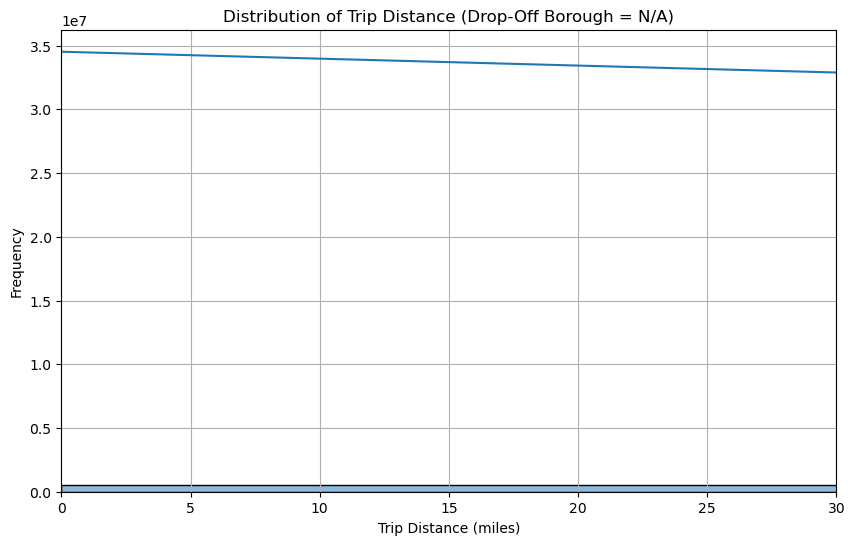

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(unknown_df["trip_distance"], bins=50, kde=True)
plt.title("Distribution of Trip Distance (Drop-Off Borough = N/A)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.xlim(0, 30)  # optional: limit extreme values
plt.grid(True)
plt.show()


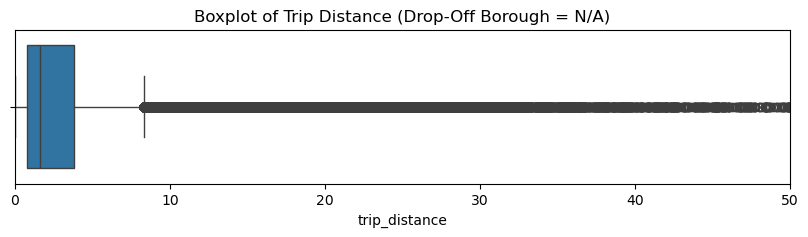

In [17]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=unknown_df, x="trip_distance")
plt.title("Boxplot of Trip Distance (Drop-Off Borough = N/A)")
plt.xlim(0, 50)
plt.show()


In [18]:
unknown_df["trip_distance"].describe(percentiles=[0.25, 0.5, 0.75])


count    533418.000000
mean          4.640958
std         203.067167
min           0.000000
25%           0.800000
50%           1.650000
75%           3.810000
max      126360.460000
Name: trip_distance, dtype: float64

In [23]:
unknown_df[unknown_df["trip_distance"] > 100]


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type,trip_duration_sec,trip_duration_min
5641,2023-01-09 15:44:58,2023-01-09 16:02:35,1.0,9674.67,17.7,19.20,1.0,2,1057.0,17.616667
6003,2023-03-20 21:58:22,2023-03-20 23:53:08,1.0,106.62,300.0,333.05,5.0,1,6886.0,114.766667
10309,2024-08-17 16:33:24,2024-08-17 17:01:57,1.0,5381.49,39.4,58.34,1.0,1,1713.0,28.550000
10334,2024-07-06 14:40:53,2024-07-06 14:55:24,1.0,5395.60,19.1,30.03,1.0,1,871.0,14.516667
10914,2024-05-01 12:10:15,2024-05-01 17:00:14,1.0,116.76,300.0,321.38,5.0,1,17399.0,289.983333
...,...,...,...,...,...,...,...,...,...,...
520687,2024-08-04 18:41:07,2024-08-04 22:05:25,1.0,151.08,921.4,922.40,4.0,2,12258.0,204.300000
522290,2024-09-22 14:34:16,2024-09-22 15:08:01,2.0,5366.15,26.8,28.30,1.0,2,2025.0,33.750000
525904,2024-12-22 15:09:42,2024-12-22 17:47:37,1.0,125.77,250.0,278.00,5.0,1,9475.0,157.916667
527383,2023-12-03 16:42:58,2023-12-03 18:56:03,1.0,101.90,372.6,381.04,1.0,1,7985.0,133.083333


In [20]:
unknown_df["tpep_pickup_datetime"] = pd.to_datetime(unknown_df["tpep_pickup_datetime"])
unknown_df["tpep_dropoff_datetime"] = pd.to_datetime(unknown_df["tpep_dropoff_datetime"])


In [21]:
# In seconds
unknown_df["trip_duration_sec"] = (unknown_df["tpep_dropoff_datetime"] - unknown_df["tpep_pickup_datetime"]).dt.total_seconds()

# In minutes
unknown_df["trip_duration_min"] = unknown_df["trip_duration_sec"] / 60


In [22]:
unknown_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type,trip_duration_sec,trip_duration_min
0,2023-04-23 16:56:18,2023-04-23 17:21:16,1.0,8.95,37.3,54.42,1.0,1,1498.0,24.966667
1,2023-06-23 19:01:01,2023-06-23 19:01:03,1.0,0.00,-3.0,-7.00,1.0,3,2.0,0.033333
2,2023-07-03 07:39:45,2023-07-03 07:45:48,1.0,1.11,7.9,14.28,1.0,1,363.0,6.050000
3,2023-07-20 18:34:08,2023-07-20 18:52:58,1.0,0.00,10.0,16.50,1.0,2,1130.0,18.833333
4,2023-02-13 17:21:43,2023-02-13 17:36:14,1.0,2.72,16.3,27.36,1.0,1,871.0,14.516667


In [25]:
unknown_df["avg_speed_mph"] = unknown_df["trip_distance"] / (unknown_df["trip_duration_min"] / 60)


In [26]:
unknown_df[unknown_df["avg_speed_mph"] > 500].sort_values("avg_speed_mph", ascending=False)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type,trip_duration_sec,trip_duration_min,avg_speed_mph
91,2023-04-13 16:08:22,2023-04-13 16:08:22,1.0,0.01,87.3,104.76,5.0,1,0.0,0.000000,inf
203672,2023-05-15 22:59:04,2023-05-15 22:59:04,1.0,0.04,3.0,5.50,1.0,2,0.0,0.000000,inf
206131,2023-09-10 18:26:28,2023-09-10 18:26:28,1.0,13.51,53.4,54.90,1.0,2,0.0,0.000000,inf
36893,2024-08-19 18:57:25,2024-08-19 18:57:25,1.0,0.03,3.0,5.50,1.0,2,0.0,0.000000,inf
36635,2023-12-06 15:49:30,2023-12-06 15:49:30,6.0,0.02,87.6,87.62,5.0,1,0.0,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...
424166,2023-03-27 20:03:01,2023-03-27 20:03:58,NaN,7.97,51.2,52.00,NaN,0,57.0,0.950000,503.368421
241772,2023-08-14 17:08:12,2023-08-14 17:08:44,NaN,4.46,23.2,24.00,NaN,0,32.0,0.533333,501.750000
62266,2023-02-10 19:02:27,2023-02-10 19:02:52,NaN,3.48,42.2,43.00,NaN,0,25.0,0.416667,501.120000
64188,2023-12-24 11:38:52,2023-12-24 11:39:15,3.0,3.20,90.0,109.15,5.0,1,23.0,0.383333,500.869565


In [28]:
unknown_df[unknown_df['tpep_pickup_datetime'] != unknown_df['tpep_dropoff_datetime'] ]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type,trip_duration_sec,trip_duration_min,avg_speed_mph
0,2023-04-23 16:56:18,2023-04-23 17:21:16,1.0,8.95,37.3,54.42,1.0,1,1498.0,24.966667,21.508678
1,2023-06-23 19:01:01,2023-06-23 19:01:03,1.0,0.00,-3.0,-7.00,1.0,3,2.0,0.033333,0.000000
2,2023-07-03 07:39:45,2023-07-03 07:45:48,1.0,1.11,7.9,14.28,1.0,1,363.0,6.050000,11.008264
3,2023-07-20 18:34:08,2023-07-20 18:52:58,1.0,0.00,10.0,16.50,1.0,2,1130.0,18.833333,0.000000
4,2023-02-13 17:21:43,2023-02-13 17:36:14,1.0,2.72,16.3,27.36,1.0,1,871.0,14.516667,11.242250


In [31]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [36]:
spark.sql(""" select count(*) from main where tpep_pickup_datetime = tpep_dropoff_datetime """).show()

+--------+
|count(1)|
+--------+
|   25029|
+--------+



In [52]:
zero_time =unknown_df[
    unknown_df["tpep_pickup_datetime"] > unknown_df["tpep_dropoff_datetime"]
]


In [53]:
len(zero_time)

1832

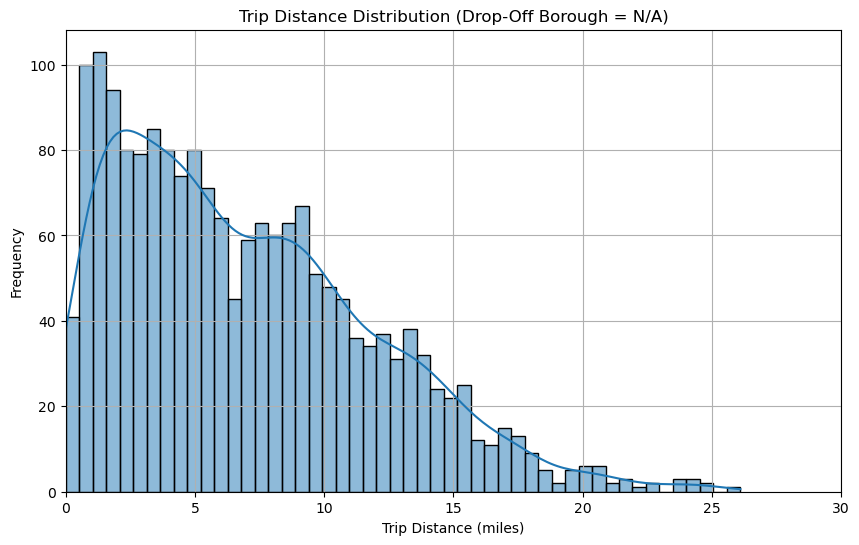

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(zero_time["trip_distance"], bins=50, kde=True)
plt.title("Trip Distance Distribution (Drop-Off Borough = N/A)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.xlim(0, 30)  # adjust as needed to clip extreme outliers
plt.grid(True)
plt.show()


In [55]:
zero_time["trip_distance"].value_counts().sort_values(ascending=False)


trip_distance
1.57     8
1.47     7
3.47     7
0.94     7
0.78     6
        ..
8.74     1
0.73     1
2.21     1
20.38    1
12.96    1
Name: count, Length: 1077, dtype: int64

In [56]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [59]:
df_cleaned.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [68]:
df_cleaned = df[
    (df["tpep_pickup_datetime"] <= df["tpep_dropoff_datetime"]) &
    (df["trip_distance"] >= 0)
]


In [58]:
df_cleaned["avg_speed_mph"] = df_cleaned["trip_distance"] / (df_cleaned["trip_duration_min"] / 60)


TypeError: 'DataFrame' object does not support item assignment

In [74]:
df_cleaned.createOrReplaceTempView("clean")


In [71]:
df_cleaned = spark.sql(""" 
SELECT
    *,
    trip_distance / (NULLIF(trip_duration_min, 0) / 60.0) AS avg_speed_mph
FROM clean

""")

In [72]:
df_cleaned.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_su

In [79]:
too_fast = spark.sql("""
select * from clean where avg_speed_mph >100""")

In [81]:
too_fast.createOrReplaceTempView('fast')

In [82]:
too_fast

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_su

In [83]:
spark.sql(""" 
select count(*)
          from fast
          """).show()

+--------+
|count(1)|
+--------+
|   30261|
+--------+



In [84]:
too_fast_pd = too_fast.toPandas()

In [85]:
too_fast_pd.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,trip_duration_min,temperature_2m,precipitation,windspeed_10m,cloudcover,rain,snowfall,temperature_category,weather_condition_summary,avg_speed_mph
0,1,2023-01-20 16:56:13,2023-01-20 16:56:56,1.0,10.4,5.0,N,3,0.0,1.25,...,0.72,7.9,0.0,25.4,14.0,0.0,0.0,Cold,Windy,866.666667
1,1,2023-01-15 17:00:04,2023-01-15 17:00:17,0.0,1.7,1.0,N,2,3.0,2.50,...,0.22,4.0,0.0,26.2,4.0,0.0,0.0,Cold,Windy,463.636364
2,1,2023-01-10 17:11:57,2023-01-10 17:12:19,1.0,4.3,1.0,N,3,0.0,0.00,...,0.37,5.7,0.0,9.6,100.0,0.0,0.0,Cold,Overcast,697.297297
3,1,2023-01-16 17:42:08,2023-01-16 17:42:16,1.0,0.8,1.0,N,3,0.0,0.00,...,0.13,5.6,0.0,6.2,0.0,0.0,0.0,Cold,Windy,369.230769
4,1,2023-01-23 14:35:41,2023-01-23 14:35:50,1.0,2.6,1.0,N,3,3.0,2.50,...,0.15,2.6,0.9,19.6,100.0,0.9,0.0,Cold,Rainy,1040.000000


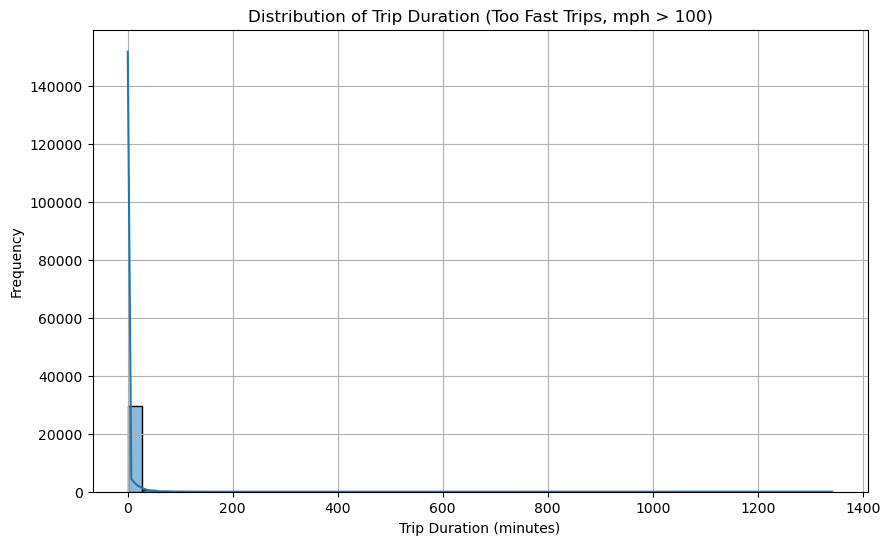

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(too_fast_pd["trip_duration_min"], bins=50, kde=True)
plt.title("Distribution of Trip Duration (Too Fast Trips, mph > 100)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [89]:
too_fast_pd["pu_zone"].value_counts().sort_values(ascending=False)


pu_zone
Outside of NYC                       3275
JFK Airport                          3237
Long Island City/Hunters Point       1173
N/A                                  1115
Times Sq/Theatre District             838
                                     ... 
Van Cortlandt Park                      1
Manhattan Beach                         1
Astoria Park                            1
Great Kills                             1
University Heights/Morris Heights       1
Name: count, Length: 248, dtype: int64

In [91]:
spark.sql("""select do_zone,count(*) c from main group by 1 order by c desc limit 20 """).show()

+--------------------+-------+
|             do_zone|      c|
+--------------------+-------+
|Upper East Side N...|3470355|
|Upper East Side S...|3329071|
|      Midtown Center|3024586|
|Times Sq/Theatre ...|2489610|
|         Murray Hill|2341124|
|        Midtown East|2266540|
| Lincoln Square East|2209797|
|Upper West Side S...|2192559|
|     Lenox Hill West|2067276|
|        East Chelsea|2042429|
|       Midtown North|1965271|
|        Clinton East|1948358|
|            Union Sq|1866615|
|Penn Station/Madi...|1748701|
|Upper West Side N...|1743230|
|       Midtown South|1716197|
|Sutton Place/Turt...|1650046|
|        East Village|1629970|
|      Yorkville West|1615881|
|     Lenox Hill East|1588994|
+--------------------+-------+



In [95]:
unknown_df['payment_type'].value_counts()

payment_type
1    407808
2     92226
0     14616
4     10100
3      8668
Name: count, dtype: int64

In [96]:
unknown_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,RatecodeID,payment_type,trip_duration_sec,trip_duration_min,avg_speed_mph
0,2023-04-23 16:56:18,2023-04-23 17:21:16,1.0,8.95,37.3,54.42,1.0,1,1498.0,24.966667,21.508678
1,2023-06-23 19:01:01,2023-06-23 19:01:03,1.0,0.00,-3.0,-7.00,1.0,3,2.0,0.033333,0.000000
2,2023-07-03 07:39:45,2023-07-03 07:45:48,1.0,1.11,7.9,14.28,1.0,1,363.0,6.050000,11.008264
3,2023-07-20 18:34:08,2023-07-20 18:52:58,1.0,0.00,10.0,16.50,1.0,2,1130.0,18.833333,0.000000
4,2023-02-13 17:21:43,2023-02-13 17:36:14,1.0,2.72,16.3,27.36,1.0,1,871.0,14.516667,11.242250


In [97]:
unknown_df["fare_amount"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])


count    533418.000000
mean         27.367757
std          41.711249
min        -997.000000
25%           9.300000
50%          14.900000
75%          31.700000
95%          83.200000
99%         186.000000
max        5000.000000
Name: fare_amount, dtype: float64

25/05/26 19:01:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 919376 ms exceeds timeout 120000 ms
25/05/26 19:01:09 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/26 19:01:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [5]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [6]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|weather_condition_summary|
+--------+--

In [7]:
df.createOrReplaceTempView('main')

In [8]:
 spark.sql(""" select pu_zone, count(*) c from main group by 1 order by c desc limit 20""").show()

+--------------------+-------+
|             pu_zone|      c|
+--------------------+-------+
|         JFK Airport|3982298|
|Upper East Side S...|3707236|
|      Midtown Center|3680648|
|Upper East Side N...|3326480|
|        Midtown East|2772600|
|Penn Station/Madi...|2667269|
|Times Sq/Theatre ...|2661840|
|   LaGuardia Airport|2600767|
| Lincoln Square East|2570714|
|         Murray Hill|2308256|
|       Midtown North|2280288|
|Upper West Side S...|2203004|
|            Union Sq|2134336|
|        East Chelsea|2114332|
|        Clinton East|2061324|
|        East Village|1858254|
|     Lenox Hill West|1835684|
|       Midtown South|1826939|
|        West Village|1800815|
|            Gramercy|1627180|
+--------------------+-------+



In [9]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pu_borough',
 'pu_zone',
 'pu_service_zone',
 'do_borough',
 'do_zone',
 'do_service_zone',
 'pickup_hour',
 'trip_duration_min',
 'temperature_2m',
 'precipitation',
 'windspeed_10m',
 'cloudcover',
 'rain',
 'snowfall',
 'temperature_category',
 'weather_condition_summary']

In [10]:
df = spark.sql(""" 
select m.*,
CASE 
  WHEN pu_zone IN ('JFK Airport', 'LaGuardia Airport') 
       OR airport_fee > 0 
  THEN 1
  ELSE 0
END AS is_airport_pickup
from
 main m
""")

In [17]:
df.createOrReplaceTempView('main')

In [15]:
df = spark.sql(
    """
select
    m.*,
    trip_distance / (NULLIF(trip_duration_min, 0) / 60.0) AS avg_speed_mph

from
    main m
"""
)

In [18]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_category|we

In [19]:
df = spark.sql(
    """ 
SELECT *,
  -- Rush hour: 7:10 AM or 4:7 PM
  CASE 
    WHEN HOUR(tpep_pickup_datetime) BETWEEN 7 AND 10 
      OR HOUR(tpep_pickup_datetime) BETWEEN 16 AND 19 
    THEN 1 
    ELSE 0 
  END AS is_rush_hour,

  -- Weekend: Saturday (6) or Sunday (0)
  CASE 
    WHEN DAYOFWEEK(tpep_pickup_datetime) IN (1, 7) THEN 1 
    ELSE 0 
  END AS is_weekend,

  -- Tip percentage (avoid div-by-zero)
  ROUND(
    CASE 
      WHEN fare_amount > 0 THEN tip_amount * 100.0 / fare_amount 
      ELSE NULL 
    END, 2
  ) AS tip_pct

FROM main"""
)

In [20]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LocalOptimizedSpark") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/02 18:27:17 WARN Utils: Your hostname, Duys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.30.28.199 instead (on interface en0)
25/06/02 18:27:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 18:27:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [21]:
df.write.mode("overwrite").parquet("output/may26_versioned")


In [23]:
df = spark.read.parquet('output/may26_versioned')

In [25]:
df.createOrReplaceTempView('main')

In [24]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [39]:
spark.sql(
"""
select
    -- sum(case when trip_duration_min < 0 then 1 else 0 end)*100.0/count(*)
percentile_approx(avg_speed_mph, 0.01) AS p01,
  percentile_approx(avg_speed_mph, 0.05) AS p05,
  percentile_approx(avg_speed_mph, 0.25) AS p25,
  percentile_approx(avg_speed_mph, 0.5)  AS p50,
  percentile_approx(avg_speed_mph, 0.75) AS p75,
  percentile_approx(avg_speed_mph, 0.95) AS p95,
  percentile_approx(avg_speed_mph, 0.99) AS p99,
  max(avg_speed_mph)
from 
    main
where
    -- store_and_fwd_flag = 'Y' or store_and_fwd_flag is null
    store_and_fwd_flag = 'N'

 """).show()

+---+---+-----------------+-----------------+----+----------------+-----------------+------------------+
|p01|p05|              p25|              p50| p75|             p95|              p99|max(avg_speed_mph)|
+---+---+-----------------+-----------------+----+----------------+-----------------+------------------+
|0.0|3.8|6.867924528301887|9.362808842652795|13.0|24.7891350964975|35.46137787056367|1952427.7665995979|
+---+---+-----------------+-----------------+----+----------------+-----------------+------------------+



In [40]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [42]:
spark.sql(
"""
select
    -- sum(case when trip_duration_min < 0 then 1 else 0 end)*100.0/count(*)
percentile_approx(avg_speed_mph, 0.01) AS p01,
  percentile_approx(avg_speed_mph, 0.05) AS p05,
  percentile_approx(avg_speed_mph, 0.25) AS p25,
  percentile_approx(avg_speed_mph, 0.5)  AS p50,
  percentile_approx(avg_speed_mph, 0.75) AS p75,
  percentile_approx(avg_speed_mph, 0.95) AS p95,
  percentile_approx(avg_speed_mph, 0.99) AS p99,
  max(avg_speed_mph)
from 
    main

 """).show()

+---+------------------+-----------------+-----+------------------+------------------+------------------+------------------+
|p01|               p05|              p25|  p50|               p75|               p95|               p99|max(avg_speed_mph)|
+---+------------------+-----------------+-----+------------------+------------------+------------------+------------------+
|0.0|3.6164383561643842|6.858762399622106|9.375|13.007194244604314|24.632152588555858|35.278195488721806|         5379164.6|
+---+------------------+-----------------+-----+------------------+------------------+------------------+------------------+



## MPH outlier
* ~60% are airport pick up

In [45]:
# Register view
# df.createOrReplaceTempView("taxi_data")

# Compute p99 in Python
# p99 = df.approxQuantile("avg_speed_mph", [0.99], 0.01)[0]

# Then use it in SQL
mph_outlier = spark.sql(f"""
    SELECT *
    FROM main
    WHERE avg_speed_mph > 35.278195488721806
""")


In [47]:
mph_outlier.createOrReplaceTempView("outlier")

In [50]:
spark.sql(
""" 
select
    pu_borough,
    count(*)
from
    outlier
group by 1
order by 2 desc
"""
).show()

+-------------+--------+
|   pu_borough|count(1)|
+-------------+--------+
|       Queens|  567800|
|    Manhattan|  196682|
|     Brooklyn|   11893|
|      Unknown|    7749|
|          N/A|    7361|
|        Bronx|    3068|
|Staten Island|     820|
|          EWR|     553|
+-------------+--------+



In [55]:
spark.sql(
""" 
select
    pu_zone,
    count(*),
    count(*)/sum(count(*)) over () *100.0
from
    main
group by 1
order by 2 desc

"""
).show()

25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+--------+----------------------------------------------------------------------------------------------------+
|             pu_zone|count(1)|((count(1) / sum(count(1)) OVER (ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)) * 100.0)|
+--------------------+--------+----------------------------------------------------------------------------------------------------+
|         JFK Airport| 3982298|                                                                                      5.010443766532|
|Upper East Side S...| 3707236|                                                                                   4.664366530898247|
|      Midtown Center| 3680648|                                                                                   4.630914067304475|
|Upper East Side N...| 3326480|                                                                                   4.185307322679862|
|        Midtown East| 2772600|                                      

25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:13:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [52]:
spark.sql(
""" 
select
    pu_zone,
    count(*)/sum(count(*)) over () *100.0
from
    outlier
group by 1
order by 2 desc
"""
).show()

25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+----------------------------------------------------------------------------------------------------+
|             pu_zone|((count(1) / sum(count(1)) OVER (ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)) * 100.0)|
+--------------------+----------------------------------------------------------------------------------------------------+
|         JFK Airport|                                                                                  53.643680442654215|
|   LaGuardia Airport|                                                                                  11.000268869216486|
|Times Sq/Theatre ...|                                                                                   2.007347416719645|
|       East Elmhurst|                                                                                  1.6554302786942503|
| UN/Turtle Bay South|                                                                                  1.2092832750783364|
|       

25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:11:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [56]:
mph_outlier.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|     pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|tempera

In [57]:
spark.sql(
""" 
select
    do_zone,
    count(*)/sum(count(*)) over () *100.0
from
    outlier
group by 1
order by 2 desc
"""
).show()

25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+----------------------------------------------------------------------------------------------------+
|             do_zone|((count(1) / sum(count(1)) OVER (ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)) * 100.0)|
+--------------------+----------------------------------------------------------------------------------------------------+
|      Outside of NYC|                                                                                  11.060073423911268|
|         JFK Airport|                                                                                   9.792744551629172|
|   LaGuardia Airport|                                                                                   7.542912280789922|
|      Newark Airport|                                                                                  5.6745225058610975|
|         Murray Hill|                                                                                  1.8314516676173411|
|      Y

25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/27 17:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [58]:
mph_outlier.

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|     pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|tempera

In [61]:
spark.sql(
""" 
select
min(avg_speed_mph),
approx_percentile(avg_speed_mph, 0.25),
approx_percentile(avg_speed_mph, 0.5),
approx_percentile(avg_speed_mph, 0.75),
approx_percentile(avg_speed_mph, 0.95),
approx_percentile(avg_speed_mph, 0.99),
max(avg_speed_mph)
from
    outlier

"""
).show()

+------------------+---------------------------------------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+------------------+
|min(avg_speed_mph)|approx_percentile(avg_speed_mph, 0.25, 10000)|approx_percentile(avg_speed_mph, 0.5, 10000)|approx_percentile(avg_speed_mph, 0.75, 10000)|approx_percentile(avg_speed_mph, 0.95, 10000)|approx_percentile(avg_speed_mph, 0.99, 10000)|max(avg_speed_mph)|
+------------------+---------------------------------------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+------------------+
| 35.27823240589198|                           36.900185988840676|                           39.10480349344978|                            42.78151260504201|                            57.03112

In [62]:
mph_outlier.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|     pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|tempera

In [63]:
spark.sql(
""" 
select
min(trip_duration_min),
approx_percentile(trip_duration_min, 0.25),
approx_percentile(trip_duration_min, 0.5),
approx_percentile(trip_duration_min, 0.75),
approx_percentile(trip_duration_min, 0.95),
approx_percentile(trip_duration_min, 0.99),
max(trip_duration_min)
from
    outlier

"""
).show()

+----------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------+
|min(trip_duration_min)|approx_percentile(trip_duration_min, 0.25, 10000)|approx_percentile(trip_duration_min, 0.5, 10000)|approx_percentile(trip_duration_min, 0.75, 10000)|approx_percentile(trip_duration_min, 0.95, 10000)|approx_percentile(trip_duration_min, 0.99, 10000)|max(trip_duration_min)|
+----------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------+
|                  0.02|                                             15.8|                                   

In [64]:
spark.sql(
""" 
select
*
from
    outlier
where
    trip_duration_min = 1442.48

"""
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------------+---------------+----------+--------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+-----------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|      pu_zone|pu_service_zone|do_borough|       do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|temperature_catego

In [65]:
mph_outlier.createOrReplaceTempView('outlier')

In [67]:
spark.sql(
""" 
select
min(trip_duration_min),
approx_percentile(trip_duration_min, 0.25),
approx_percentile(trip_duration_min, 0.5),
approx_percentile(trip_duration_min, 0.75),
approx_percentile(trip_duration_min, 0.95),
approx_percentile(trip_duration_min, 0.99),
max(trip_duration_min)
from
    outlier
where
    avg_speed_mph >100

"""
).show()

+----------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------+
|min(trip_duration_min)|approx_percentile(trip_duration_min, 0.25, 10000)|approx_percentile(trip_duration_min, 0.5, 10000)|approx_percentile(trip_duration_min, 0.75, 10000)|approx_percentile(trip_duration_min, 0.95, 10000)|approx_percentile(trip_duration_min, 0.99, 10000)|max(trip_duration_min)|
+----------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+----------------------+
|                  0.02|                                              0.1|                                   

In [4]:
quick_df = spark.sql(
""" 
SELECT *
FROM main
WHERE
    -- ✅ Basic required fields must be present
    avg_speed_mph IS NOT NULL
    AND trip_duration_min IS NOT NULL
    AND trip_distance IS NOT NULL
    AND total_amount IS NOT NULL
    AND pu_borough IS NOT NULL AND do_borough IS NOT NULL

    -- ⚡ Speed must be realistic
    AND avg_speed_mph BETWEEN 1 AND 100

    -- ⏱️ Duration must be plausible
    AND trip_duration_min BETWEEN 1 AND 180

    -- 📍 Trip must be within NYC scope
    AND trip_distance <= 100

    -- 💵 Fare must make sense
    AND total_amount >= 1

    -- 🗺️ Zones must be valid
    AND pu_zone NOT IN ('Unknown', 'N/A')
    AND do_zone NOT IN ('Unknown', 'N/A')
    AND pu_borough NOT IN ('Unknown', 'N/A')
    AND do_borough NOT IN ('Unknown', 'N/A')

    -- 🚫 Valid RatecodeID range
    AND RatecodeID BETWEEN 1 AND 6

    -- 🚩 Remove extreme outliers from corrupt math
    AND NOT (trip_duration_min < 1 AND trip_distance > 5)

    -- ⚠️ Filter invalid negotiated fare trips
    AND NOT (
        RatecodeID = 5
        AND trip_distance > 100
        AND total_amount < 20
    )
"""
)

{"ts": "2025-06-02 14:58:53.673", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[TABLE_OR_VIEW_NOT_FOUND] The table or view `main` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01", "context": {"errorClass": "TABLE_OR_VIEW_NOT_FOUND"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o37.sql.\n: org.apache.spark.sql.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `main` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXIST

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `main` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01; line 3 pos 5;
'Project [*]
+- 'Filter (((((isnotnull('avg_speed_mph) AND isnotnull('trip_duration_min)) AND isnotnull('trip_distance)) AND (isnotnull('total_amount) AND isnotnull('pu_borough))) AND ((isnotnull('do_borough) AND 'between('avg_speed_mph, 1, 100)) AND ('between('trip_duration_min, 1, 180) AND ('trip_distance <= 100)))) AND (((('total_amount >= 1) AND NOT 'pu_zone IN (Unknown,N/A)) AND (NOT 'do_zone IN (Unknown,N/A) AND NOT 'pu_borough IN (Unknown,N/A))) AND ((NOT 'do_borough IN (Unknown,N/A) AND 'between('RatecodeID, 1, 6)) AND (NOT (('trip_duration_min < 1) AND ('trip_distance > 5)) AND NOT ((('RatecodeID = 5) AND ('trip_distance > 100)) AND ('total_amount < 20))))))
   +- 'UnresolvedRelation [main], [], false


In [70]:
quick_df.write.mode("overwrite").parquet("output/prototype_cleaned_data/")


In [2]:
quick_df = spark.read.parquet('output/prototype_cleaned_data/')

In [3]:
zone = spark.read.csv('raw/zone_clusters_full.csv',header = True)

In [4]:
zone.createOrReplaceTempView('zone')

In [5]:
quick_df.show()

25/06/02 18:28:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

25/06/03 14:16:13 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 150751 ms exceeds timeout 120000 ms
25/06/03 14:16:13 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/03 14:16:21 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

In [41]:
zone.show()

+----------+-------------+--------------------+------------+---------------+
|LocationID|      Borough|                Zone|service_zone|        Cluster|
+----------+-------------+--------------------+------------+---------------+
|         1|          EWR|      Newark Airport|         EWR| Newark Airport|
|         2|       Queens|         Jamaica Bay|   Boro Zone|   Queens South|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|    Bronx South|
|         4|    Manhattan|       Alphabet City| Yellow Zone|Other Manhattan|
|         5|Staten Island|       Arden Heights|   Boro Zone|  Staten Island|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|  Staten Island|
|         7|       Queens|             Astoria|   Boro Zone|   Queens North|
|         8|       Queens|        Astoria Park|   Boro Zone|   Queens North|
|         9|       Queens|          Auburndale|   Boro Zone|   Other Queens|
|        10|       Queens|        Baisley Park|   Boro Zone|   Other Queens|

In [42]:
quick_df = spark.sql(
""" 
SELECT 
    q.*, 
    pu.Cluster AS pu_cluster, 
    do.Cluster AS po_cluster
FROM quick q
LEFT JOIN zone AS pu
    ON q.pu_zone = pu.zone
LEFT JOIN zone AS do
    ON q.do_zone = do.zone
"""
)

In [45]:
quick_df.createOrReplaceTempView('quick')

In [43]:
quick_df = spark.sql(
""" 
select
    q,
    case when q.pu_zone = q.do_zone then 1 else 0 end as is_same_zone_trip
from
    quick q

"""
)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+-----------------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipit

In [52]:
test = spark.sql('''SELECT
    pu_zone,
    do_zone,
    COUNT(*) AS trip_count,
    AVG(trip_distance) AS avg_trip_distance
FROM quick
GROUP BY pu_zone, do_zone
HAVING COUNT(*) >= 50
ORDER BY avg_trip_distance DESC''')


In [55]:
test_data = test.toPandas()

In [63]:
test_data.head()

,pu_zone,do_zone,trip_count,avg_trip_distance
0,JFK Airport,Charleston/Tottenville,151,37.645695
1,JFK Airport,Newark Airport,5728,36.813605
2,JFK Airport,Rossville/Woodrow,141,35.364681
3,JFK Airport,Eltingville/Annadale/Prince's Bay,278,34.869460
4,JFK Airport,Arden Heights,169,34.003314


In [73]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

# Example: show all distinct clusters in your zone DataFrame
query = """
SELECT 
    *
FROM test_data
order by trip_count desc
"""

test = pysqldf(query)
test.head(100)


,pu_zone,do_zone,trip_count,avg_trip_distance
0,Upper East Side South,Upper East Side North,520265,1.064418
1,Upper East Side North,Upper East Side South,443216,1.044580
2,Upper East Side South,Upper East Side South,342542,0.660602
3,Upper East Side North,Upper East Side North,330498,0.645044
4,Midtown Center,Upper East Side South,245595,1.074942
5,Upper East Side South,Midtown Center,226235,1.054147
6,Midtown Center,Upper East Side North,206777,1.945665
7,Lincoln Square East,Upper West Side South,196051,1.001900
8,Upper East Side South,Midtown East,193385,0.983715
9,Upper West Side South,Lincoln Square East,190713,0.882149


              Cluster
0         Bronx North
1         Bronx South
2      Brooklyn North
3      Brooklyn South
4         JFK Airport
5   LaGuardia Airport
6     Lower Manhattan
7   Midtown Manhattan
8      Newark Airport
9               Other
10     Other Brooklyn
11    Other Manhattan
12       Other Queens
13       Queens North
14       Queens South
15      Rikers Island
16      Staten Island
17    Upper East Side
18    Upper Manhattan
19    Upper West Side


In [9]:
quick_df.createOrReplaceTempView('quick')

# more feature, specifically same pu zone analyseis


In [24]:
spark.sql(
""" 
with pu as (
select
    distinct pu_zone
from
    quick
),
do as (
select
    distinct do_zone
from
    quick
)
select distinct case when pu_zone is null then do_zone else null end from do left join pu on pu.pu_zone = do.do_zone
"""
).show()

+------------------------------------------------------+
|CASE WHEN (pu_zone IS NULL) THEN do_zone ELSE NULL END|
+------------------------------------------------------+
|                                                  NULL|
+------------------------------------------------------+



In [23]:
spark.sql(
    """ 
select
    *
from
    quick
where
    pu_zone = 'Rikers Island'

"""
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+-------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|      pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|snowfall|tempe

In [11]:
spark.sql(
""" 
select
    pu_borough,
    count(*)
from
    quick
group by 1
"""
).show()

+-------------+--------+
|   pu_borough|count(1)|
+-------------+--------+
|       Queens| 6630368|
|     Brooklyn|  241209|
|Staten Island|     756|
|          EWR|     517|
|    Manhattan|63435237|
|        Bronx|   20437|
+-------------+--------+



In [18]:
spark.sql(
""" 
select
    count( distinct pu_zone), count( distinct do_zone)
from
    quick

"""
).show()

+-----------------------+-----------------------+
|count(DISTINCT pu_zone)|count(DISTINCT do_zone)|
+-----------------------+-----------------------+
|                    260|                    259|
+-----------------------+-----------------------+



In [7]:
test = spark.sql(
""" 
select
    q.*
from
    quick q
where
    q.pu_zone = q.do_zone
"""                 )

In [12]:
test.count()

2734767

In [14]:
test.createOrReplaceTempView('same_loc_trip')

In [8]:
spark.sql(
""" 
select
        min(trip_distance),
        percentile_approx(trip_distance, 0.25) AS p25,
        percentile_approx(trip_distance, 0.5)  AS median,
        AVG(trip_distance) AS mean,
        percentile_approx(trip_distance, 0.75) AS p75,
        percentile_approx(trip_distance, 0.95) AS p95,
        percentile_approx(trip_distance, 0.99) AS p99,
        max(trip_distance)
from
    same_loc_trip
"""
).show()

{"ts": "2025-06-02 15:10:09.097", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01", "context": {"errorClass": "TABLE_OR_VIEW_NOT_FOUND"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o37.sql.\n: org.apache.spark.sql.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or D

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01; line 12 pos 4;
'Project [unresolvedalias('min('trip_distance)), 'percentile_approx('trip_distance, 0.25) AS p25#44, 'percentile_approx('trip_distance, 0.5) AS median#45, 'AVG('trip_distance) AS mean#46, 'percentile_approx('trip_distance, 0.75) AS p75#47, 'percentile_approx('trip_distance, 0.95) AS p95#48, 'percentile_approx('trip_distance, 0.99) AS p99#49, unresolvedalias('max('trip_distance))]
+- 'UnresolvedRelation [same_loc_trip], [], false


In [7]:
spark.sql(
""" 
select
        min(trip_duration_min),
        percentile_approx(trip_duration_min, 0.25) AS p25,
        percentile_approx(trip_duration_min, 0.5)  AS median,
        AVG(trip_duration_min) AS mean,
        percentile_approx(trip_duration_min, 0.75) AS p75,
        percentile_approx(trip_duration_min, 0.95) AS p95,
        percentile_approx(trip_duration_min, 0.99) AS p99,
        max(trip_duration_min)
from
    same_loc_trip
"""
).show()

{"ts": "2025-06-02 15:10:01.724", "level": "ERROR", "logger": "SQLQueryContextLogger", "msg": "[TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01", "context": {"errorClass": "TABLE_OR_VIEW_NOT_FOUND"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o37.sql.\n: org.apache.spark.sql.AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.\nIf you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.\nTo tolerate the error on drop use DROP VIEW IF EXISTS or D

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `same_loc_trip` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS. SQLSTATE: 42P01; line 12 pos 4;
'Project [unresolvedalias('min('trip_duration_min)), 'percentile_approx('trip_duration_min, 0.25) AS p25#38, 'percentile_approx('trip_duration_min, 0.5) AS median#39, 'AVG('trip_duration_min) AS mean#40, 'percentile_approx('trip_duration_min, 0.75) AS p75#41, 'percentile_approx('trip_duration_min, 0.95) AS p95#42, 'percentile_approx('trip_duration_min, 0.99) AS p99#43, unresolvedalias('max('trip_duration_min))]
+- 'UnresolvedRelation [same_loc_trip], [], false


In [3]:
quick_df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pu_borough',
 'pu_zone',
 'pu_service_zone',
 'do_borough',
 'do_zone',
 'do_service_zone',
 'pickup_hour',
 'trip_duration_min',
 'temperature_2m',
 'precipitation',
 'windspeed_10m',
 'cloudcover',
 'rain',
 'snowfall',
 'temperature_category',
 'weather_condition_summary',
 'is_airport_pickup',
 'avg_speed_mph',
 'is_rush_hour',
 'is_weekend',
 'tip_pct']

In [ ]:
categorical_features = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'pu_borough', 'pu_zone', 'is_airport_pickup', 'is_rush_hour', 'is_weekend',
    'temperature_category', 'weather_condition_summary'
]


In [99]:
categorical_features = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'pu_borough', 'pu_zone', 'is_rush_hour', 'is_weekend',
    'temperature_category', 'weather_condition_summary'
]

In [73]:
numerical_features = [
    'passenger_count', 'trip_distance',
    'temperature_2m', 'rain','snowfall'
]


In [76]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Index and encode categorical features
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") for col in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_features]

# Assemble all features
assembler_inputs = [f"{col}_vec" for col in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_features")

# Scale features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

preprocessing_stages = indexers + encoders + [assembler, scaler]


In [77]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define model
lr = LinearRegression(featuresCol="features", labelCol="trip_duration_min")

# Full pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=preprocessing_stages + [lr])

# Split
train_df, test_df = quick_df.randomSplit([0.8, 0.2], seed=42)

# Train
lr_model = pipeline.fit(train_df)

# Predict
preds = lr_model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="trip_duration_min", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(preds)
print(f"Linear Model MAE: {mae:.2f} minutes")


25/05/27 21:19:46 ERROR Executor: Exception in task 3.0 in stage 173.0 (TID 1128)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] User defined function (`VectorAssembler$$Lambda$5913/0x00000008011c13d8`: (struct<VendorID_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,RatecodeID_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,store_and_fwd_flag_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,payment_type_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,pu_borough_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,pu_zone_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_airport_pickup_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_rush_hour_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_weekend_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,tem

Py4JJavaError: An error occurred while calling o308.fit.
: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] User defined function (`VectorAssembler$$Lambda$5913/0x00000008011c13d8`: (struct<VendorID_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,RatecodeID_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,store_and_fwd_flag_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,payment_type_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,pu_borough_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,pu_zone_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_airport_pickup_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_rush_hour_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,is_weekend_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,temperature_category_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,weather_condition_summary_vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,passenger_count:double,trip_distance:double,temperature_2m:double,rain:double,snowfall:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) failed due to: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".. SQLSTATE: 39000
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:195)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:165)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:87)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:295)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:264)
	at scala.collection.IterableOnceOps.foreach(IterableOnce.scala:619)
	at scala.collection.IterableOnceOps.foreach$(IterableOnce.scala:617)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:935)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:264)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:145)
	... 27 more


In [78]:
quick_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [79]:
quick_df.createOrReplaceTempView('quick')

In [81]:
spark.sql(
""" 
select
    sum(case when temperature_2m is null then 1 else 0 end)*100.0/count(*)
from
    quick

"""
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [83]:
spark.sql(
""" 
select
    count(*)
from
    quick

"""
).show()

+--------+
|count(1)|
+--------+
|70328524|
+--------+



In [85]:
quick_df = quick_df.dropna(how = 'any')


In [86]:
sample_df = quick_df.sample(withReplacement=False, fraction=0.01, seed=42)


In [100]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define model
lr = LinearRegression(featuresCol="features", labelCol="trip_duration_min", regParam=0.1,elasticNetParam=0 
)

# Full pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=preprocessing_stages + [lr])

# Split
train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=42)

# Train
lr_model = pipeline.fit(train_df)

# Predict
preds = lr_model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="trip_duration_min", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(preds)
print(f"Linear Model MAE: {mae:.2f} minutes")


Linear Model MAE: 5.04 minutes


In [89]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration_min", maxDepth=10, numTrees=50, seed=42)

pipeline_rf = Pipeline(stages=preprocessing_stages + [rf])
rf_model = pipeline_rf.fit(train_df)

rf_preds = rf_model.transform(test_df)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="trip_duration_min", predictionCol="prediction", metricName="mae")
rf_mae = evaluator.evaluate(rf_preds)
print(f"Random Forest MAE: {rf_mae:.2f} minutes")


25/05/27 21:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1251.1 KiB
25/05/27 21:44:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/27 21:44:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/27 21:44:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/27 21:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1047.4 KiB
25/05/27 21:44:29 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
25/05/27 21:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1837.6 KiB


Random Forest MAE: 4.52 minutes


In [90]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="trip_duration_min", maxIter=50, maxDepth=6, seed=42)

pipeline_gbt = Pipeline(stages=preprocessing_stages + [gbt])
gbt_model = pipeline_gbt.fit(train_df)

gbt_preds = gbt_model.transform(test_df)

gbt_mae = evaluator.evaluate(gbt_preds)
print(f"GBT MAE: {gbt_mae:.2f} minutes")


GBT MAE: 4.38 minutes


In [91]:
quick_df.createOrReplaceTempView('fast')

In [92]:
non_airport = spark.sql(
""" 
select
    *
from
    fast
where
    is_airport_pickup = 0
"""
)

In [93]:
non_airport.createOrReplaceTempView('non_airport')

In [94]:
non_airport_sample = non_airport.sample(withReplacement=False, fraction=0.01, seed=42)


In [95]:
non_airport_sample.count()

641014

# Linear regression | Non airport

In [101]:
categorical_features = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'pu_borough', 'pu_zone', 'is_rush_hour', 'is_weekend',
    'temperature_category', 'weather_condition_summary'
]

In [102]:
numerical_features = [
    'passenger_count', 'trip_distance',
    'temperature_2m', 'rain','snowfall'
]


In [103]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Index and encode categorical features
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") for col in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_features]

# Assemble all features
assembler_inputs = [f"{col}_vec" for col in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_features")

# Scale features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

preprocessing_stages = indexers + encoders + [assembler, scaler]


In [104]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define model
lr = LinearRegression(featuresCol="features", labelCol="trip_duration_min", regParam=0.1,elasticNetParam=0 
)

# Full pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=preprocessing_stages + [lr])

# Split
train_df, test_df = non_airport_sample.randomSplit([0.8, 0.2], seed=42)

# Train
lr_model = pipeline.fit(train_df)

# Predict
preds = lr_model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="trip_duration_min", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(preds)
print(f"Linear Model MAE: {mae:.2f} minutes")


Linear Model MAE: 4.45 minutes


In [105]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration_min", maxDepth=10, numTrees=50, seed=42)

pipeline_rf = Pipeline(stages=preprocessing_stages + [rf])
rf_model = pipeline_rf.fit(train_df)

rf_preds = rf_model.transform(test_df)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="trip_duration_min", predictionCol="prediction", metricName="mae")
rf_mae = evaluator.evaluate(rf_preds)
print(f"Random Forest MAE: {rf_mae:.2f} minutes")

25/05/27 22:07:25 WARN DAGScheduler: Broadcasting large task binary with size 1215.5 KiB
25/05/27 22:07:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/27 22:07:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/27 22:07:31 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/05/27 22:07:34 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
25/05/27 22:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1499.5 KiB


Random Forest MAE: 4.07 minutes


In [106]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="trip_duration_min", maxIter=50, maxDepth=6, seed=42)

pipeline_gbt = Pipeline(stages=preprocessing_stages + [gbt])
gbt_model = pipeline_gbt.fit(train_df)

gbt_preds = gbt_model.transform(test_df)

gbt_mae = evaluator.evaluate(gbt_preds)
print(f"GBT MAE: {gbt_mae:.2f} minutes")

GBT MAE: 3.91 minutes


In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


In [109]:
# Assume you already have this from: sample_df.toPandas()
df = non_airport_sample.toPandas()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,cloudcover,rain,snowfall,temperature_category,weather_condition_summary,is_airport_pickup,avg_speed_mph,is_rush_hour,is_weekend,tip_pct
0,2,2023-01-15 21:09:05,2023-01-15 21:12:05,1.0,0.74,1.0,N,2,5.8,1.0,...,0.0,0.0,0.0,Cold,Windy,0,14.800000,0,1,0.00
1,2,2023-01-09 20:03:09,2023-01-09 20:11:43,1.0,1.63,1.0,N,1,10.7,1.0,...,0.0,0.0,0.0,Cold,Windy,0,11.411902,0,0,26.45
2,1,2023-01-22 18:52:33,2023-01-22 19:01:43,1.0,1.40,1.0,N,1,10.7,2.5,...,100.0,0.0,0.0,Cold,Overcast,0,9.160305,1,1,27.10
3,1,2023-01-10 20:36:31,2023-01-10 20:39:58,1.0,0.70,1.0,N,1,5.8,3.5,...,100.0,0.0,0.0,Cold,Overcast,0,12.173913,0,0,25.86
4,1,2023-01-18 18:19:25,2023-01-18 18:24:27,1.0,1.30,1.0,N,1,7.9,5.0,...,100.0,0.0,0.0,Cold,Overcast,0,15.506958,1,0,12.66


In [129]:
categorical_features = [
    'VendorID', 'store_and_fwd_flag', 'payment_type',
    'pu_borough', 'pu_zone', 'is_rush_hour', 'is_weekend','do_borough','do_zone',
    'temperature_category', 'weather_condition_summary'
]
numerical_features = [
    'passenger_count',
    'temperature_2m', 'rain','snowfall'
]


target = 'trip_duration_min'


In [130]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [131]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])


In [132]:
X = df[numerical_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE: {mae:.2f} minutes")


XGBoost MAE: 5.77 minutes


In [133]:
# Extract the one-hot encoder from the pipeline
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine with numerical columns
all_feature_names = numerical_features + list(ohe_feature_names)


<Axes: title={'center': 'Top Feature Importances'}>

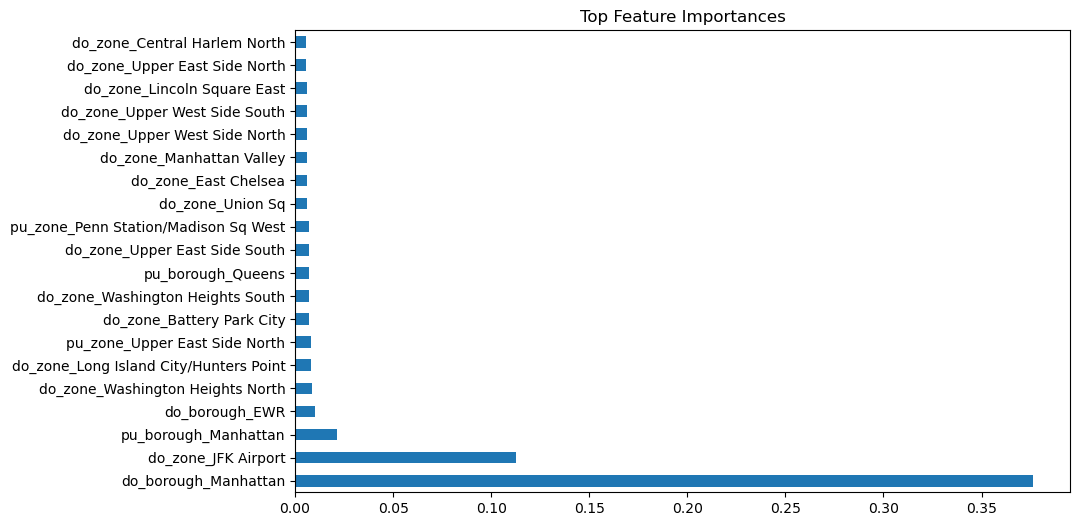

25/05/27 22:47:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 353611 ms exceeds timeout 120000 ms
25/05/27 22:47:33 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/27 22:47:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [134]:
import numpy as np
import pandas as pd

# Extract fitted model from pipeline
xgb_model = model.named_steps['regressor']

# Pair feature names with importances
importances = pd.Series(xgb_model.feature_importances_, index=all_feature_names)

# Sort and display top N
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6), title="Top Feature Importances")


In [3]:
quick_df.show()

25/05/30 23:04:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+-------------------+-----------------+--------------+-------------+-------------+----------+----+--------+--------------------+-------------------------+-----------------+------------------+------------+----------+-------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pu_borough|             pu_zone|pu_service_zone|do_borough|             do_zone|do_service_zone|        pickup_hour|trip_duration_min|temperature_2m|precipitation|windspeed_10m|cloudcover|rain|

In [4]:
quick_df.createOrReplaceTempView('fast')

In [ ]:
quick_df = spark.sql(
"""
select
    f,
    case when f.pu_zone = f.do_zone then 1 else 0 end as same_zone_drive
from
    fast f
"""
                     )